In [1]:
import os
import math
import numpy as np
import pandas as pd

import sklearn
import tensorflow as tf

# data processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# model training
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping

# for plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.subplots as sp

2023-09-16 23:36:30.901387: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-16 23:36:30.928770: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-16 23:36:30.999165: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-16 23:36:31.000286: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 23:36:31.764084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# for trading
from backtesting import Backtest, Strategy

/home/dani/.local/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
# my util functions
from utils.utils import format_num

from pipeline_steps.data_processing import load_data_for_ticker
from pipeline_steps.model_training_steps import train_val_test_split, create_data_sequence, normalize_data
from pipeline_steps.model_prediction import calc_metrics, plot_true_vs_predicted, plot_difference, plot_prices

In [4]:
%matplotlib inline

<h2>Table of Contents</h2>
<ul>
    <a href='#Load-in-data'>Load in data</a><br>
    <a href='#Data-splitting'>Data splitting</a><br>
    <a href='#Data-normalization'>Data normalization</a>
    <a href='#Model-training'>Model training</a><br>
    <a href='#Model-prediction'>Model prediction</a><br>
    <a href='#Summary'>Summary</a><br>
</ul>

In [5]:
# setting a seed
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)
sklearn.random.seed(seed)

## Load in data

In [6]:
# ticker symbols for the companies
ticker_symbol = 'GOOG' # TSLA, AAPL, MSFT

Most recent file will be used: 
	datasets/processed_data/GOOG/2023_09_16_18_55_55.csv
Rows: 4403
Columns: 16
Date range: 2005/06/03 - 2022/11/28


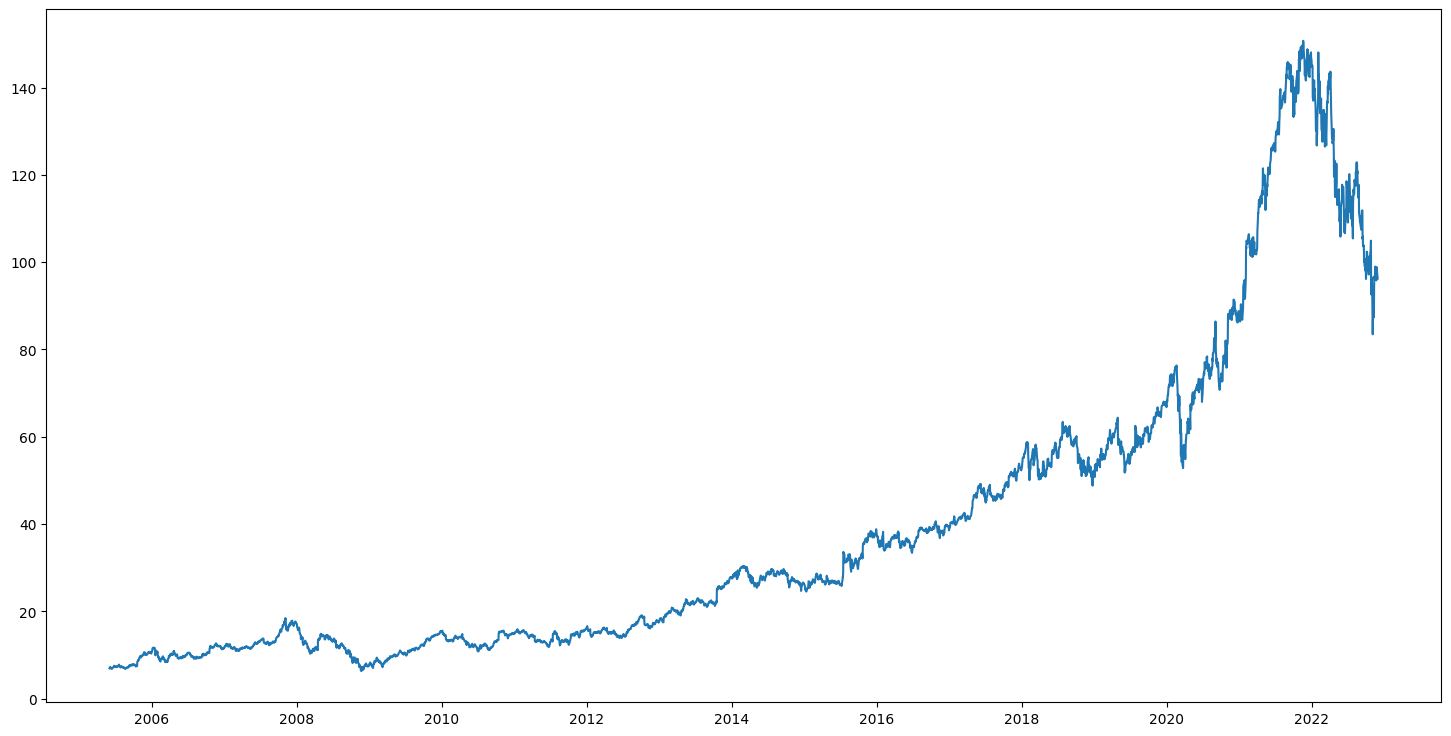

In [7]:
# checking if file exists for given ticker
path = f'datasets/processed_data/{ticker_symbol}'
if os.path.exists:
    path += f'/{sorted(os.listdir(path))[-1]}'
    
    print(f'Most recent file will be used: \n\t{path}')
    df = load_data_for_ticker(ticker_symbol, path, info=1)
else:
    print('No folder found for ticker!')

In [8]:
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close,ticker,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_50,SMA_200,RSI_14,ROC_14,DIFF_10
Date,,,,,,,,,,,,,,,,
2005-06-03,2005-06-03,6.909352,7.142976,754108027,7.205492,6.980336,6.980336,GOOG,0.449593,0.075923,0.373670,5.466899,4.469567,79.570214,22.256154,0.000996
2005-06-06,2005-06-06,7.019439,7.033387,904413304,7.316327,7.246339,7.246339,GOOG,0.467185,0.074812,0.392373,5.522535,4.493303,82.771400,25.920792,-0.105604
2005-06-07,2005-06-07,7.230399,7.399764,976566743,7.461781,7.300635,7.300635,GOOG,0.479975,0.070082,0.409893,5.578177,4.516318,83.345063,25.732409,-0.131507
2005-06-08,2005-06-08,6.924047,7.293911,1031889331,7.302379,6.962901,6.962901,GOOG,0.457585,0.038153,0.419432,5.627985,4.537509,68.145384,16.892449,0.242591
2005-06-09,2005-06-09,6.987808,7.091420,660109011,7.185567,7.131021,7.131021,GOOG,0.448239,0.023046,0.425193,5.680717,4.560104,70.982302,19.704824,0.084683


In [9]:
df.columns

Index(['Date', 'Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close',
       'ticker', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'SMA_50',
       'SMA_200', 'RSI_14', 'ROC_14', 'DIFF_10'],
      dtype='object')

 # Setting up data

In [10]:
used_columns = [
    'Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close',
    'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 
    'SMA_50', 'SMA_200',
    'RSI_14', 
    'ROC_14', 
    'DIFF_10']

predicted_column = len(used_columns)-1
predicted_column_name = used_columns[predicted_column]
prediction_range = int(used_columns[predicted_column].split('_').pop())

print(f'The predicted column: {predicted_column_name}')
print(f'The prediction is {prediction_range} days into the future.')

The predicted column: DIFF_10
The prediction is 10 days into the future.


In [11]:
X = df[used_columns[:predicted_column]]
y = df[used_columns[predicted_column]]

## Data splitting

In [12]:
train_prec = 0.7
val_prec = 0.15
test_prec = 0.15

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, train_prec, val_prec, test_prec)

Dataset ranges: 
	Train: 0-3081
	Val: 3082-3741
	Test: 3742-4402


## Data normalization

Normalizing stock prices is a tricky business. Different time periods can have drastically different price ranges, and if we normalize al these different periods together, then larger ranges will have a disproportionate effect on all data.

**Solution:**
We will separate our data into different periods, or windows, and normalize within them. 

Note: This will result in breaks between the periods, but if the window is big enough than this won't be a problem as there will only be a few of them.

In [14]:
# the size, in precentage, that one window will be (normalization will happen in each window separately)
grouping_precentage = 0.2
scaler = StandardScaler()

In [15]:
normalize_data(X_train, X_val, X_test, scaler, grouping_precentage, verbose=1)

Full data size: 4403
Normalization window's size: 881
Data normalization started...
	Normalized training data from 0 to 881
	Normalized training data from 881 to 1762
	Normalized training data from 1762 to 2643
	Normalized training data from 2643 to 3524
	 Training data end was at 3082
	Normalized validation data from 0 to 881
	 Training data end was at 660
	Normalized testing data from 0 to 881
	 Training data end was at 661


## Data sequences

In [16]:
sequence_length = 30

In [17]:
# creating sequences from data
print('Creating training sequences...')
X_train_seq, y_train_seq = create_data_sequence(X_train, y_train, sequence_length)
print('\nCreating validation sequences...')
X_val_seq, y_val_seq = create_data_sequence(X_val, y_val, sequence_length)
print('\nCreating testing sequences...')
X_test_seq, y_test_seq = create_data_sequence(X_test, y_test, sequence_length)

Creating training sequences...
Original shape: 
	X:(3082, 13) and y:(3082,)
Sequence shape: 
	X:(3052, 30, 13) and y:(3052,)

Creating validation sequences...
Original shape: 
	X:(660, 13) and y:(660,)
Sequence shape: 
	X:(630, 30, 13) and y:(630,)

Creating testing sequences...
Original shape: 
	X:(661, 13) and y:(661,)
Sequence shape: 
	X:(631, 30, 13) and y:(631,)


# Model training

In [18]:
# params for training
feature_num = len(used_columns)-1

epochs = 100
batch_size = 128

optimizer = 'adam'
loss = 'mean_squared_error'

In [19]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [27]:
# creating model
model = Sequential([
    LSTM(32, activation='relu', input_shape=(sequence_length, feature_num), return_sequences=True, seed=seed),
    Dropout(0.2, seed=seed),
    LSTM(84, activation='relu', input_shape=(sequence_length, feature_num), return_sequences=False, seed=seed),
    Dropout(0.2, seed=seed),
    Dense(1)
])

In [28]:
# compile model
model.compile(optimizer=optimizer, loss=loss)

# train model
model.fit(X_train_seq, y_train_seq, 
          epochs=epochs, batch_size=batch_size,
          validation_data=(X_val_seq, y_val_seq),
          callbacks=callbacks)

Epoch 1/100
24/24 [==============================] - 2s 39ms/step - loss: 1.0525 - val_loss: 11.8349
Epoch 2/100
24/24 [==============================] - 1s 33ms/step - loss: 1.0106 - val_loss: 191.3430
Epoch 3/100
24/24 [==============================] - 1s 33ms/step - loss: 0.9878 - val_loss: 40.3758
Epoch 4/100
24/24 [==============================] - 1s 26ms/step - loss: 0.9646 - val_loss: 141.7445
Epoch 5/100
24/24 [==============================] - 1s 26ms/step - loss: 0.9426 - val_loss: 275.1469
Epoch 6/100
24/24 [==============================] - 1s 28ms/step - loss: 0.9199 - val_loss: 248.7609


# Model prediction

In [29]:
# predict
y_pred = model.predict(X_test_seq).reshape(-1)

20/20 [==============================] - 0s 4ms/step


## Results

In [30]:
y_true = y_test_seq

In [31]:
calc_metrics(y_true, y_pred)

{'MAE': 23.00398033016646,
 'MSE': 726.4332352636333,
 'max-error': 74.88388061523438,
 'R2': -19.29888653371431}

In [32]:
# creating a dataset for plotting 
plot_data_start = X_train.shape[0] + X_val.shape[0] - 1 + sequence_length
plot_data_end = plot_data_start + y_pred.shape[0]
X_plot = df.iloc[plot_data_start:plot_data_end, :]

In [33]:
plot_true_vs_predicted(X_plot, y_true, y_pred)

In [34]:
plot_difference(X_plot, y_true, y_pred)

In [35]:
plot_prices(X_plot, y_true, y_pred)

# Trading
We will only trade on the test data.

In [ ]:
starting_money = 10_000 # usd
current_money = 0 # usd

prices = X_plot['close']
predicted_change = y_pred

In [ ]:
start_date = X_plot.loc[0, 'date'].date()
print(f'The test data starts at {start_date}')
end_date = X_plot.loc[X_plot.shape[0]-1, 'date'].date()
print(f'The test data ends at {end_date}')

In [ ]:
trading_data = pd.concat([X_plot, pd.Series(y_pred, name=predicted_column_name)], axis=1)
trading_data = trading_data.set_index('date')

In [ ]:
trading_data.head()

In [ ]:
class MyStrategy(Strategy):
    buying_amount = 1
    
    def init(self):
        target_values = self.data[predicted_column_name]
        self.sellout_point = np.median(target_values[target_values<0])   
        
        future_prices = self.data.Close + target_values
        self.trusted_max = (np.median(future_prices) + np.max(future_prices))/2
        self.trusted_min = (np.median(future_prices) + np.min(future_prices))/2
        
    
    def next(self):
        current_price = self.data.Close[-1]
        predicted_price = current_price + self.data[predicted_column_name][-1]
        
        # buying if we can trust it
        if self.trusted_max > predicted_price and predicted_price > self.trusted_min:
            if predicted_price > 0:
                self.buy(size=self.buying_amount)
        
        # selling if we can trust it
        if self.trusted_max > predicted_price and predicted_price > self.trusted_min:
            if self.data[predicted_column_name][-1]  < self.sellout_point:
                self.position.close()

In [ ]:
bt = Backtest(trading_data, MyStrategy, cash=starting_money, commission=0.005)

In [ ]:
output = bt.run()
bt.plot(filename='trading/plots/test', open_browser=True)

In [ ]:
output

# SHARP RATIO > 1 is good

### Just trust the model
Will try to buy every day, when the prediction is that the price will go up.

In [ ]:
# this will store the resulting profits
profits = pd.DataFrame(columns=['method', 'profit'])

In [ ]:
def calc_profit(start_money, end_money, end_stocks, end_price):
    return int(end_money + end_stocks*end_price - start_money)

In [ ]:
def calc_BAH_profit(start_money, prices, verbose=0):
    end_stocks = int(start_money / prices[0])
    end_price = prices[len(prices)-1]
    end_money = start_money - end_stocks*end_price

    profit = calc_profit(start_money, end_money, end_stocks, end_price)
    
    if verbose:
        print(f'Remaining money: {end_money}')
        print(f'Bought stocks: {end_stocks}') 
        
    profits.loc[profits.shape[0]] = [f'BAH', profit]
    return profit

In [ ]:
BAH_profit = calc_BAH_profit(starting_money, prices, verbose=1)
print(BAH_profit)

In [ ]:
def calc_MODEL_profit(start_money, prices, predicted_change, 
                      buying_freq=1, buying_amount=1, min_limit=5, max_limit=250, verbose=0):
    current_money = start_money
    current_stocks = 0
    
    for i in range(0, len(prices), buying_freq):
        current_price = prices[i]
        current_predicted_change = predicted_change[i]
        
        # if we can trust the model
        if min_limit <= abs(current_predicted_change) and abs(current_predicted_change) <= max_limit:
            # if we can buy the stock
            if current_price*buying_amount <= current_money:
                current_stocks += buying_amount
                current_money -= current_price*buying_amount
    
    end_money = current_money
    end_stocks = current_stocks
    end_price = prices[len(prices)-1]
    profit = calc_profit(start_money, end_money, end_stocks, end_price)
    
    if verbose:
        print(f'Remaining money: {end_money}')
        print(f'Bought stocks: {end_stocks}') 
    
    profits.loc[profits.shape[0]] = [f'model_{min_limit}_{max_limit}', profit]
    return profit

In [ ]:
limits = [(0,1000),(5,300),(10, 150),(20, 75), (25, 50)]
for limit in limits:
    model_profit = calc_MODEL_profit(starting_money, prices, predicted_change,
                                     buying_freq=1, buying_amount=1, 
                                     min_limit=limit[0], max_limit=limit[1])
    print(f'{model_profit} profit (before taxes or any fees)')

In [ ]:
profits['profit'] = profits['profit'].apply(lambda x: format_num(x))
profits

# Summary

In [ ]:
# TODO
# save params and results for later comparison
# make comparison with earlier models
# look how much profit can be made by following the model (make some simple algo for trading)